In [1]:
# Import data
import pandas as pd

interaction_df = pd.read_csv('goodreads_interactions.csv')

interaction_df_clean = interaction_df[['user_id', 'book_id', 'rating']][interaction_df['is_read'] == 1]

# Group by user_id and count unique book_ids
books_per_user = interaction_df_clean.groupby('user_id')['book_id'].nunique()

#Compute the 99th percentile
threshold = books_per_user.quantile(0.95)

# Step 3: Identify users at or below the threshold
valid_users = books_per_user[books_per_user <= threshold].index



# from collections import defaultdict

# user_items = filtered_df.groupby('user_id')['book_id'].apply(set).to_dict()


In [2]:
# Step 4: Filter the original dataframe
filtered_df = interaction_df_clean[interaction_df_clean['user_id'].isin(valid_users)].sample(n=1000000, random_state=42)

In [3]:
import numpy as np
import requests
import json
import io
import torch
from torch import tensor

In [4]:
import os
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 14g pyspark-shell"

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# initiate a new spark session
# spark = SparkSession.builder.appName(name='GoodReadALS').getOrCreate()
spark = SparkSession.builder.master("local").appName("test").getOrCreate()


# from py4j.java_gateway import java_import   
# java_import(spark._sc._jvm, "org.apache.spark.sql.api.python.*")



# # spark.conf.set("spark.sql.execution.arrow.enabled","true")
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [5]:
# create spark dataframe 

dfs = spark.createDataFrame(filtered_df)

In [ ]:
# # show first 5 rows of spark dataframe
# dfs.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
| 382396|  36143|     2|
| 361287|   8434|     3|
|  31603|  56353|     4|
|   2798| 377527|     5|
| 464725| 485419|     5|
+-------+-------+------+
only showing top 5 rows


In [6]:
# rename cols as spark accepst 'user' & 'movie' col names
dfs = dfs.withColumnsRenamed({
    'user_id': 'user',
    'book_id': 'book',
})

# split data in train & test sets 
dfs_train, dfs_test = dfs.randomSplit([0.8, 0.2], 42)

In [ ]:
# # import ALS model from spark
# from pyspark.ml.recommendation import ALS

# # initialise the model 
# als = ALS(maxIter=10, regParam=0.1, rank=10, userCol="user", itemCol="book", 
#           ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

# # train model 
# als_model = als.fit(dfs_train)

In [ ]:
# # generate predictions
# dfs_preds = als_model.transform(dfs_test)

# # show preds dataframe
# dfs_preds.show(5)

+------+----+------+----------+
|  user|book|rating|prediction|
+------+----+------+----------+
|389033|   1|     5| 2.1310742|
|150169|   1|     0| 3.3514004|
| 27042|   3|     0| 2.9014518|
|132447|   3|     5|  3.778429|
|211443|   3|     4| 3.2781525|
+------+----+------+----------+
only showing top 5 rows


In [ ]:
# from pyspark.ml.evaluation import RegressionEvaluator

# # initiate evaluator
# eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
# # calculate rmse
# rmse = eval.evaluate(dfs_preds)

# # reset metric and evaluate mse, R2, mae & explained variance
# r2 = eval.evaluate(dfs_preds, {eval.metricName: 'r2'})
# mae = eval.evaluate(dfs_preds, {eval.metricName: 'mae'})
# var = eval.evaluate(dfs_preds, {eval.metricName: 'var'})


# print(
#     "RMSE score = {}".format(rmse),
#     "R2 score = {}".format(r2),
#     "MAE score = {}".format(mae),
#     "Explained variance score = {}".format(var),
#     sep="\n"
# )

RMSE score = 1.4948449566714848
R2 score = -0.13209222250054586
MAE score = 1.1370772241389808
Explained variance score = 1.0855434997631053


In [7]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

# initiate model without hyperparams
# initialise the model
als = ALS(userCol="user", itemCol="book", ratingCol="rating", 
          coldStartStrategy="drop", nonnegative=True)

# create a hyperparameter grid
param_grid = ParamGridBuilder().addGrid(
    als.rank, [5,10,15,20]
    ).addGrid(
        als.maxIter, [10]
    ).addGrid(
        als.regParam, [0.01, 0.05, 0.15, 0.20]
    ).build()

# create an evaluation metric
eval = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

# use cross validator to run models
cv = CrossValidator(
    estimator=als, 
    estimatorParamMaps=param_grid,
    evaluator=eval,
    numFolds=3
)

als_model = cv.fit(dfs_train)

# get rmse scores from trained model
rmse_scores = als_model.avgMetrics
# get params map
param_maps = als_model.getEstimatorParamMaps()

model_acc = []
# iterate using zip 
for param_map, rmse in zip(param_maps, rmse_scores): 
  params = {param.name: value for param, value in param_map.items()}
  params['rmse'] = rmse
  model_acc.append(params)

# convert model_acc data into a pandas DataFrame
df_acc = pd.DataFrame(model_acc)

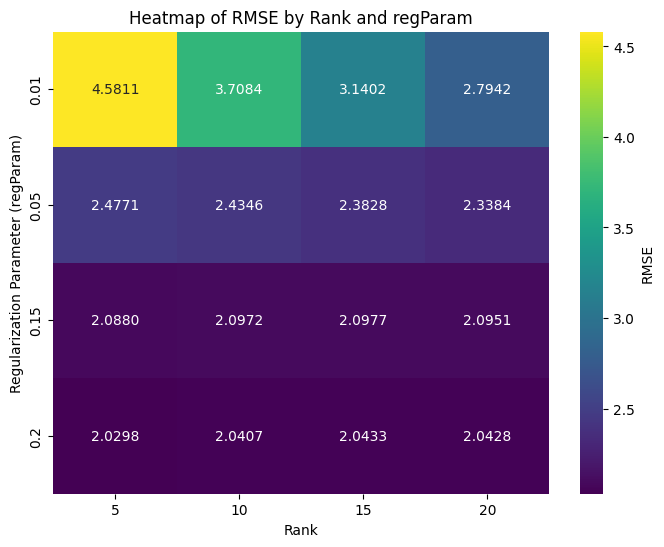

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


# Pivot the DataFrame to create a grid for heatmap
heatmap_data = df_acc.pivot(index='regParam', columns='rank', values='rmse')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='viridis', cbar_kws={'label': 'RMSE'})
plt.title('Heatmap of RMSE by Rank and regParam')
plt.xlabel('Rank')
plt.ylabel('Regularization Parameter (regParam)')
plt.show()

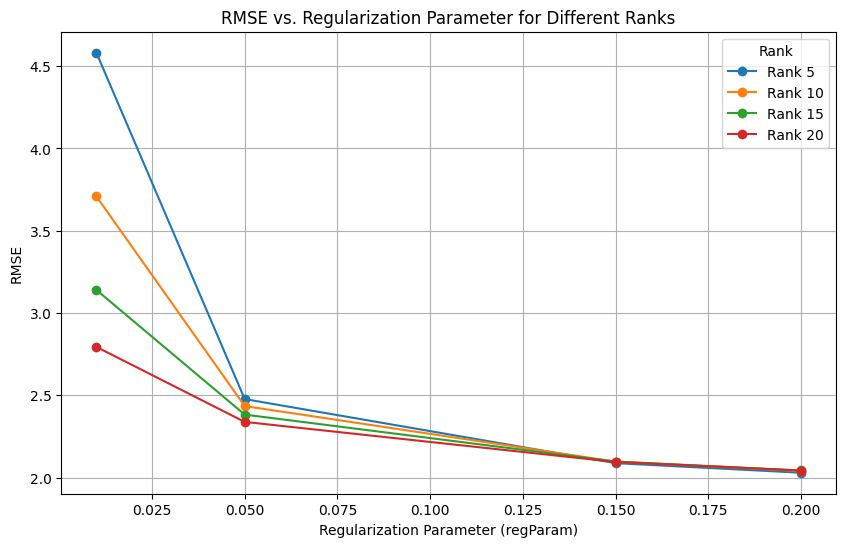

In [10]:
# Create a line plot for each rank
plt.figure(figsize=(10, 6))

for rank in sorted(set(d['rank'] for d in model_acc)):
    rank_data = [d for d in model_acc if d['rank'] == rank]
    reg_params = [d['regParam'] for d in rank_data]
    rmses = [d['rmse'] for d in rank_data]
    plt.plot(reg_params, rmses, marker='o', label=f'Rank {rank}')

# Add labels and legend
plt.title('RMSE vs. Regularization Parameter for Different Ranks')
plt.xlabel('Regularization Parameter (regParam)')
plt.ylabel('RMSE')
plt.legend(title='Rank')
plt.grid(True)
plt.show()

In [11]:
best_model = als_model.bestModel

In [ ]:
# import pickle

# # save the model to disk
# filename = 'ALS_recommender.sav'
# pickle.dump(best_model, open(filename, 'wb'))

TypeError: cannot pickle '_thread.RLock' object

In [23]:
import joblib

# save the model to disk
filename = 'ALS_recommender.joblib'
joblib.dump(best_model, filename, compress=3)

TypeError: cannot pickle '_thread.RLock' object

In [35]:
# Save the trained ALS model

best_model.write().overwrite().save("als_model")


Py4JJavaError: An error occurred while calling o10566.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
	at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$2(QueryExecution.scala:155)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:155)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:154)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:169)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:164)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:446)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:164)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:126)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:131)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:192)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:622)
	at org.apache.spark.sql.classic.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:273)
	at org.apache.spark.sql.classic.DataFrameWriter.saveInternal(DataFrameWriter.scala:241)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:118)
	at org.apache.spark.sql.DataFrameWriter.text(DataFrameWriter.scala:409)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:445)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:453)
	at org.apache.spark.ml.recommendation.ALSModel$ALSModelWriter.saveImpl(ALS.scala:565)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:169)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:75)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:580)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:1583)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:789)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:298)
		at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:314)
		at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:1116)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:798)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:838)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:837)
		at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:810)
		at org.apache.hadoop.fs.ChecksumFileSystem.mkdirs(ChecksumFileSystem.java:988)
		at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.setupJob(FileOutputCommitter.java:356)
		at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.setupJob(HadoopMapReduceCommitProtocol.scala:190)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:268)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:306)
		at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:189)
		at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:195)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:117)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:115)
		at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:129)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$2(QueryExecution.scala:155)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:162)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:268)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:124)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
		at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
		at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:124)
		at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:291)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:123)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:77)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:233)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:155)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
		at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:154)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:169)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:164)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:470)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:446)
		at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:164)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:126)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 24 more
Caused by: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://cwiki.apache.org/confluence/display/HADOOP2/WindowsProblems
	at org.apache.hadoop.util.Shell.fileNotFoundException(Shell.java:601)
	at org.apache.hadoop.util.Shell.getHadoopHomeDir(Shell.java:622)
	at org.apache.hadoop.util.Shell.getQualifiedBin(Shell.java:645)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:742)
	at org.apache.hadoop.util.StringUtils.<clinit>(StringUtils.java:80)
	at org.apache.hadoop.conf.Configuration.getTimeDurationHelper(Configuration.java:1954)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1912)
	at org.apache.hadoop.conf.Configuration.getTimeDuration(Configuration.java:1885)
	at org.apache.hadoop.util.ShutdownHookManager.getShutdownTimeout(ShutdownHookManager.java:183)
	at org.apache.hadoop.util.ShutdownHookManager$HookEntry.<init>(ShutdownHookManager.java:207)
	at org.apache.hadoop.util.ShutdownHookManager.addShutdownHook(ShutdownHookManager.java:304)
	at org.apache.spark.util.SparkShutdownHookManager.$anonfun$install$1(ShutdownHookManager.scala:194)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at scala.Option.fold(Option.scala:263)
	at org.apache.spark.util.SparkShutdownHookManager.install(ShutdownHookManager.scala:195)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks$lzycompute(ShutdownHookManager.scala:55)
	at org.apache.spark.util.ShutdownHookManager$.shutdownHooks(ShutdownHookManager.scala:53)
	at org.apache.spark.util.ShutdownHookManager$.addShutdownHook(ShutdownHookManager.scala:159)
	at org.apache.spark.util.ShutdownHookManager$.<clinit>(ShutdownHookManager.scala:63)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:250)
	at org.apache.spark.util.SparkFileUtils.createTempDir(SparkFileUtils.scala:103)
	at org.apache.spark.util.SparkFileUtils.createTempDir$(SparkFileUtils.scala:102)
	at org.apache.spark.util.Utils$.createTempDir(Utils.scala:99)
	at org.apache.spark.deploy.SparkSubmit.prepareSubmitEnvironment(SparkSubmit.scala:379)
	at org.apache.spark.deploy.SparkSubmit.org$apache$spark$deploy$SparkSubmit$$runMain(SparkSubmit.scala:961)
	at org.apache.spark.deploy.SparkSubmit.doRunMain$1(SparkSubmit.scala:204)
	at org.apache.spark.deploy.SparkSubmit.submit(SparkSubmit.scala:227)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:96)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1132)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1141)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scala)
Caused by: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset.
	at org.apache.hadoop.util.Shell.checkHadoopHomeInner(Shell.java:521)
	at org.apache.hadoop.util.Shell.checkHadoopHome(Shell.java:492)
	at org.apache.hadoop.util.Shell.<clinit>(Shell.java:569)
	... 27 more
